# Script para elegir 300 imágenes al azar del bucket de s3 y obtener su meta-data

## Creación del csv

### Imports

In [124]:
import boto3
import csv
import random
from io import BytesIO
from PIL import Image, ImageStat
from concurrent.futures import ThreadPoolExecutor, as_completed

### Variables globales

In [125]:
# Configuración
BUCKET_NAME = 'caetec-vacas'  # Reemplaza con tu nombre de bucket
OUTPUT_CSV = 's3_image_metadata_advanced_with_histograms.csv'
MAX_IMAGES = 300  # Número máximo de imágenes a procesar
MAX_WORKERS = 10  # Número de hilos para procesamiento paralelo

### Creamos una lista con todos los objetos de la bucket

In [126]:
def list_all_objects(s3_client, bucket):
    paginator = s3_client.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket)
    all_objects = []
    for page in page_iterator:
        contents = page.get('Contents', [])
        all_objects.extend(contents)
    return all_objects

### Vemos la cantidad de imágenes en el array (all_objects)

In [127]:
print(len(all_objects))

2189


### Procesamos cada imagen obteniendo la meta-data de la misma, witdh, height, luminosity, contrast e histogramas rgb

In [128]:
def process_object(s3_client, bucket, obj):
    key = obj['Key']
    last_modified = obj['LastModified']
    size = obj['Size']
    etag = obj['ETag']
    storage_class = obj.get('StorageClass', 'STANDARD')
    owner = obj.get('Owner', {}).get('DisplayName', 'Unknown')
    content_type = obj.get('ContentType', 'Unknown')
    
    # Inicializar variables para características avanzadas
    width, height = None, None
    luminosity, contrast = None, None
    histogram_red, histogram_green, histogram_blue = [None]*256, [None]*256, [None]*256
    
    try:
        # Descargar la imagen en memoria
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_data = response['Body'].read()
        image = Image.open(BytesIO(image_data)).convert('RGB')  # Asegurar que la imagen esté en RGB
        
        # Obtener dimensiones de la imagen
        width, height = image.size
        
        # Convertir la imagen a escala de grises para calcular luminosidad y contraste
        grayscale_image = image.convert('L')
        stat = ImageStat.Stat(grayscale_image)
        
        # Calcular la luminosidad (media de los valores de píxel)
        luminosity = stat.mean[0]
        
        # Calcular el contraste (desviación estándar de los valores de píxel)
        contrast = stat.stddev[0]
        
        # Calcular histogramas para cada canal
        histogram = image.histogram()
        # Histograma tiene 256 valores por canal (R, G, B)
        histogram_red = histogram[0:256]
        histogram_green = histogram[256:512]
        histogram_blue = histogram[512:768]
        
    except Exception as e:
        print(f"Error procesando {key}: {e}")
        # Asignar valores predeterminados o continuar según sea necesario
        width, height = None, None
        luminosity, contrast = None, None
        histogram_red, histogram_green, histogram_blue = [None]*256, [None]*256, [None]*256
    
    # Preparar los histogramas como cadenas de texto
    histogram_red_str = ';'.join(map(str, histogram_red)) if histogram_red else ''
    histogram_green_str = ';'.join(map(str, histogram_green)) if histogram_green else ''
    histogram_blue_str = ';'.join(map(str, histogram_blue)) if histogram_blue else ''
    
    return [
        key, last_modified, size, etag, 
        storage_class, owner, content_type,
        width, height, luminosity, contrast,
        histogram_red_str, histogram_green_str, histogram_blue_str
    ]

### Creamos la funcion main y escribimos en el meta-data

In [129]:
def main():
    # Inicializar el cliente de S3
    s3 = boto3.client('s3')
    
    # Listar todos los objetos en el bucket
    print("Listando objetos en el bucket...")
    all_objects = list_all_objects(s3, BUCKET_NAME)
    total_objects = len(all_objects)
    print(f"Total de objetos en el bucket: {total_objects}")
    
    if total_objects == 0:
        print("No se encontraron objetos en el bucket.")
        return
    
    # Elegir 300 objetos al azar si hay suficientes, si no, toma todos
    sample_size = min(total_objects, MAX_IMAGES)
    sampled_objects = random.sample(all_objects, sample_size)
    print(f"Seleccionando {sample_size} objetos al azar para procesar...")
    
    # Definir los encabezados del CSV
    headers = [
        'Key', 'LastModified', 'Size', 'ETag', 
        'StorageClass', 'Owner', 'ContentType',
        'Width', 'Height', 'Luminosity', 'Contrast',
        'Histogram_Red', 'Histogram_Green', 'Histogram_Blue'
    ]
    
    # Procesar los objetos en paralelo para mejorar el rendimiento
    print("Procesando objetos y extrayendo metadata...")
    processed_data = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Enviar tareas al pool de hilos
        futures = {executor.submit(process_object, s3, BUCKET_NAME, obj): obj for obj in sampled_objects}
        for future in as_completed(futures):
            data = future.result()
            processed_data.append(data)
    
    # Escribir los datos en el CSV
    print(f"Escribiendo metadata en el archivo CSV: {OUTPUT_CSV}")
    with open(OUTPUT_CSV, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Escribir encabezados
        writer.writerows(processed_data)  # Escribir filas de datos
    
    print(f"CSV creado con {sample_size} registros de metadata avanzados seleccionados al azar.")


### Corremos el programa

In [130]:
if __name__ == "__main__":
    main()

Listando objetos en el bucket...
Total de objetos en el bucket: 2189
Seleccionando 300 objetos al azar para procesar...
Procesando objetos y extrayendo metadata...
Escribiendo metadata en el archivo CSV: s3_image_metadata_advanced_with_histograms.csv
CSV creado con 300 registros de metadata avanzados seleccionados al azar.


## Creamos gráficas para visualización de la información en el csv

### Imports

In [103]:
# Importar las bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from io import BytesIO
import boto3
import random
import numpy as np

# Configurar estilos para las gráficas
sns.set(style="whitegrid")
%matplotlib inline


### Pasamor el csv a pandas

In [104]:
# Cargar el CSV en un DataFrame de pandas
df = pd.read_csv('s3_image_metadata_advanced_with_histograms.csv')

# Mostrar las primeras filas para verificar
df.head()


,Key,LastModified,Size,ETag,StorageClass,Owner,ContentType,Width,Height,Luminosity,Contrast,Histogram_Red,Histogram_Green,Histogram_Blue
0,train/5/2024-05-19-16-15-03_jpg.rf.4d6b45062c0...,2024-10-14 18:13:21+00:00,197285,"""f3aa9157e777153dec9c3fc3a4370314""",STANDARD,Unknown,Unknown,1920,1080,76.436881,65.995039,38;119;2887;9546;11954;13842;14360;10095;7211;...,178;369;4089;10539;17238;25077;27235;29744;474...,131810;70929;82633;91822;74391;58067;54774;462...
1,validation/2/2024-05-17-21-15-03_jpg.rf.121ba1...,2024-10-14 18:18:28+00:00,31519,"""9d8e514e25b03de9ae2d5e7194df776e""",STANDARD,Unknown,Unknown,640,640,13.509089,16.371630,6433;33613;25048;22196;18216;15190;13396;12034...,12954;44248;35553;27611;23651;22026;19987;1779...,104757;58279;43485;38699;32247;26709;20981;158...
2,validation/5/2024-05-17-08-55-03_jpg.rf.7ecb40...,2024-10-14 18:16:10+00:00,57803,"""0784d3aa6decd3c6a7d4c03b2c1876a9""",STANDARD,Unknown,Unknown,640,640,106.366218,61.195509,1;0;0;1;1;2;5;6;3;16;14;35;77;162;644;1408;196...,0;0;0;0;0;0;0;0;0;2;2;2;6;26;37;149;1014;1454;...,0;0;0;0;1;0;1;4;7;21;32;82;101;631;1621;1262;1...
3,train/3/2024-05-22-01-10-03_jpg.rf.4e9a4c7ffbd...,2024-10-14 18:10:39+00:00,118619,"""5353582b783086440c6ff80215a784c4""",STANDARD,Unknown,Unknown,1920,1080,11.562212,17.457831,242059;276796;180574;116915;78613;60415;49324;...,357292;363988;190063;113081;78706;62409;53270;...,653119;405395;191745;141037;115873;99542;84264...
4,train/10/2024-05-20-18-50-03_jpg.rf.093a7b376f...,2024-10-14 18:33:42+00:00,178339,"""17c5e2440aa46012264bfc608c5e0f8f""",STANDARD,Unknown,Unknown,1920,1080,70.832510,67.871926,637;714;2033;9769;16070;26464;34085;39219;6455...,49;75;365;2672;3502;12252;20530;24896;39209;59...,9896;18343;30296;43159;57224;73075;52329;52123...


### Visualizamos csv

In [105]:
df

,Key,LastModified,Size,ETag,StorageClass,Owner,ContentType,Width,Height,Luminosity,Contrast,Histogram_Red,Histogram_Green,Histogram_Blue
0,train/5/2024-05-19-16-15-03_jpg.rf.4d6b45062c0...,2024-10-14 18:13:21+00:00,197285,"""f3aa9157e777153dec9c3fc3a4370314""",STANDARD,Unknown,Unknown,1920,1080,76.436881,65.995039,38;119;2887;9546;11954;13842;14360;10095;7211;...,178;369;4089;10539;17238;25077;27235;29744;474...,131810;70929;82633;91822;74391;58067;54774;462...
1,validation/2/2024-05-17-21-15-03_jpg.rf.121ba1...,2024-10-14 18:18:28+00:00,31519,"""9d8e514e25b03de9ae2d5e7194df776e""",STANDARD,Unknown,Unknown,640,640,13.509089,16.371630,6433;33613;25048;22196;18216;15190;13396;12034...,12954;44248;35553;27611;23651;22026;19987;1779...,104757;58279;43485;38699;32247;26709;20981;158...
2,validation/5/2024-05-17-08-55-03_jpg.rf.7ecb40...,2024-10-14 18:16:10+00:00,57803,"""0784d3aa6decd3c6a7d4c03b2c1876a9""",STANDARD,Unknown,Unknown,640,640,106.366218,61.195509,1;0;0;1;1;2;5;6;3;16;14;35;77;162;644;1408;196...,0;0;0;0;0;0;0;0;0;2;2;2;6;26;37;149;1014;1454;...,0;0;0;0;1;0;1;4;7;21;32;82;101;631;1621;1262;1...
3,train/3/2024-05-22-01-10-03_jpg.rf.4e9a4c7ffbd...,2024-10-14 18:10:39+00:00,118619,"""5353582b783086440c6ff80215a784c4""",STANDARD,Unknown,Unknown,1920,1080,11.562212,17.457831,242059;276796;180574;116915;78613;60415;49324;...,357292;363988;190063;113081;78706;62409;53270;...,653119;405395;191745;141037;115873;99542;84264...
4,train/10/2024-05-20-18-50-03_jpg.rf.093a7b376f...,2024-10-14 18:33:42+00:00,178339,"""17c5e2440aa46012264bfc608c5e0f8f""",STANDARD,Unknown,Unknown,1920,1080,70.832510,67.871926,637;714;2033;9769;16070;26464;34085;39219;6455...,49;75;365;2672;3502;12252;20530;24896;39209;59...,9896;18343;30296;43159;57224;73075;52329;52123...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,validation/2/2024-05-16-23-05-03_jpg.rf.fa8129...,2024-10-14 18:18:14+00:00,25452,"""ab698b0368454ce23d5f8618ecebf687""",STANDARD,Unknown,Unknown,640,640,7.138169,11.215217,14218;58984;46931;31520;21023;18242;16514;1464...,61622;89868;50881;32737;23758;19687;16393;1420...,124410;108563;46937;32497;24514;18583;13691;97...
296,train/3/2024-05-22-04-55-02_jpg.rf.25661284a9e...,2024-10-14 18:10:43+00:00,113539,"""39f78f4dc9f7e9f547102c96861638a1""",STANDARD,Unknown,Unknown,1920,1080,10.967465,17.105128,339205;337424;187178;107532;72864;55073;44743;...,468779;417794;179238;101341;69074;55201;46364;...,706556;456681;183171;121386;94168;76689;61464;...
297,test/4/2024-05-04-06-20-02_jpg.rf.2f626f6e5a2a...,2024-10-14 18:24:34+00:00,211915,"""a893c34c148f9163803636cc078ba2a4""",STANDARD,Unknown,Unknown,1920,1080,199.751379,43.124673,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...,0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;...
298,train/1/2024-05-22-03-45-03_jpg.rf.2437cdb1be5...,2024-10-14 18:07:24+00:00,149482,"""b2538f83cccb8b51a1354e69062bff84""",STANDARD,Unknown,Unknown,1920,1080,13.816430,9.770749,2592;10494;22205;28204;30464;39057;44917;47908...,50388;73986;100165;111263;118357;120552;116528...,411988;231077;247526;244654;221548;188316;1493...


### Convertimos la cadena de histogramas en strings a int

In [106]:
# Definir una función para convertir la cadena de histograma en una lista de enteros
def histogram_str_to_list(hist_str):
    if pd.isna(hist_str) or hist_str == '':
        return [0]*256
    return list(map(int, hist_str.split(';')))

# Aplicar la función a las columnas de histogramas
df['Histogram_Red'] = df['Histogram_Red'].apply(histogram_str_to_list)
df['Histogram_Green'] = df['Histogram_Green'].apply(histogram_str_to_list)
df['Histogram_Blue'] = df['Histogram_Blue'].apply(histogram_str_to_list)

# Verificar la conversión
df[['Histogram_Red', 'Histogram_Green', 'Histogram_Blue']].head()


,Histogram_Red,Histogram_Green,Histogram_Blue
0,"[38, 119, 2887, 9546, 11954, 13842, 14360, 100...","[178, 369, 4089, 10539, 17238, 25077, 27235, 2...","[131810, 70929, 82633, 91822, 74391, 58067, 54..."
1,"[6433, 33613, 25048, 22196, 18216, 15190, 1339...","[12954, 44248, 35553, 27611, 23651, 22026, 199...","[104757, 58279, 43485, 38699, 32247, 26709, 20..."
2,"[1, 0, 0, 1, 1, 2, 5, 6, 3, 16, 14, 35, 77, 16...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 6, 26, 37...","[0, 0, 0, 0, 1, 0, 1, 4, 7, 21, 32, 82, 101, 6..."
3,"[242059, 276796, 180574, 116915, 78613, 60415,...","[357292, 363988, 190063, 113081, 78706, 62409,...","[653119, 405395, 191745, 141037, 115873, 99542..."
4,"[637, 714, 2033, 9769, 16070, 26464, 34085, 39...","[49, 75, 365, 2672, 3502, 12252, 20530, 24896,...","[9896, 18343, 30296, 43159, 57224, 73075, 5232..."


### Seleccionamos una imagen al azar y ploteamos los histogramas con la intensidad de rgb

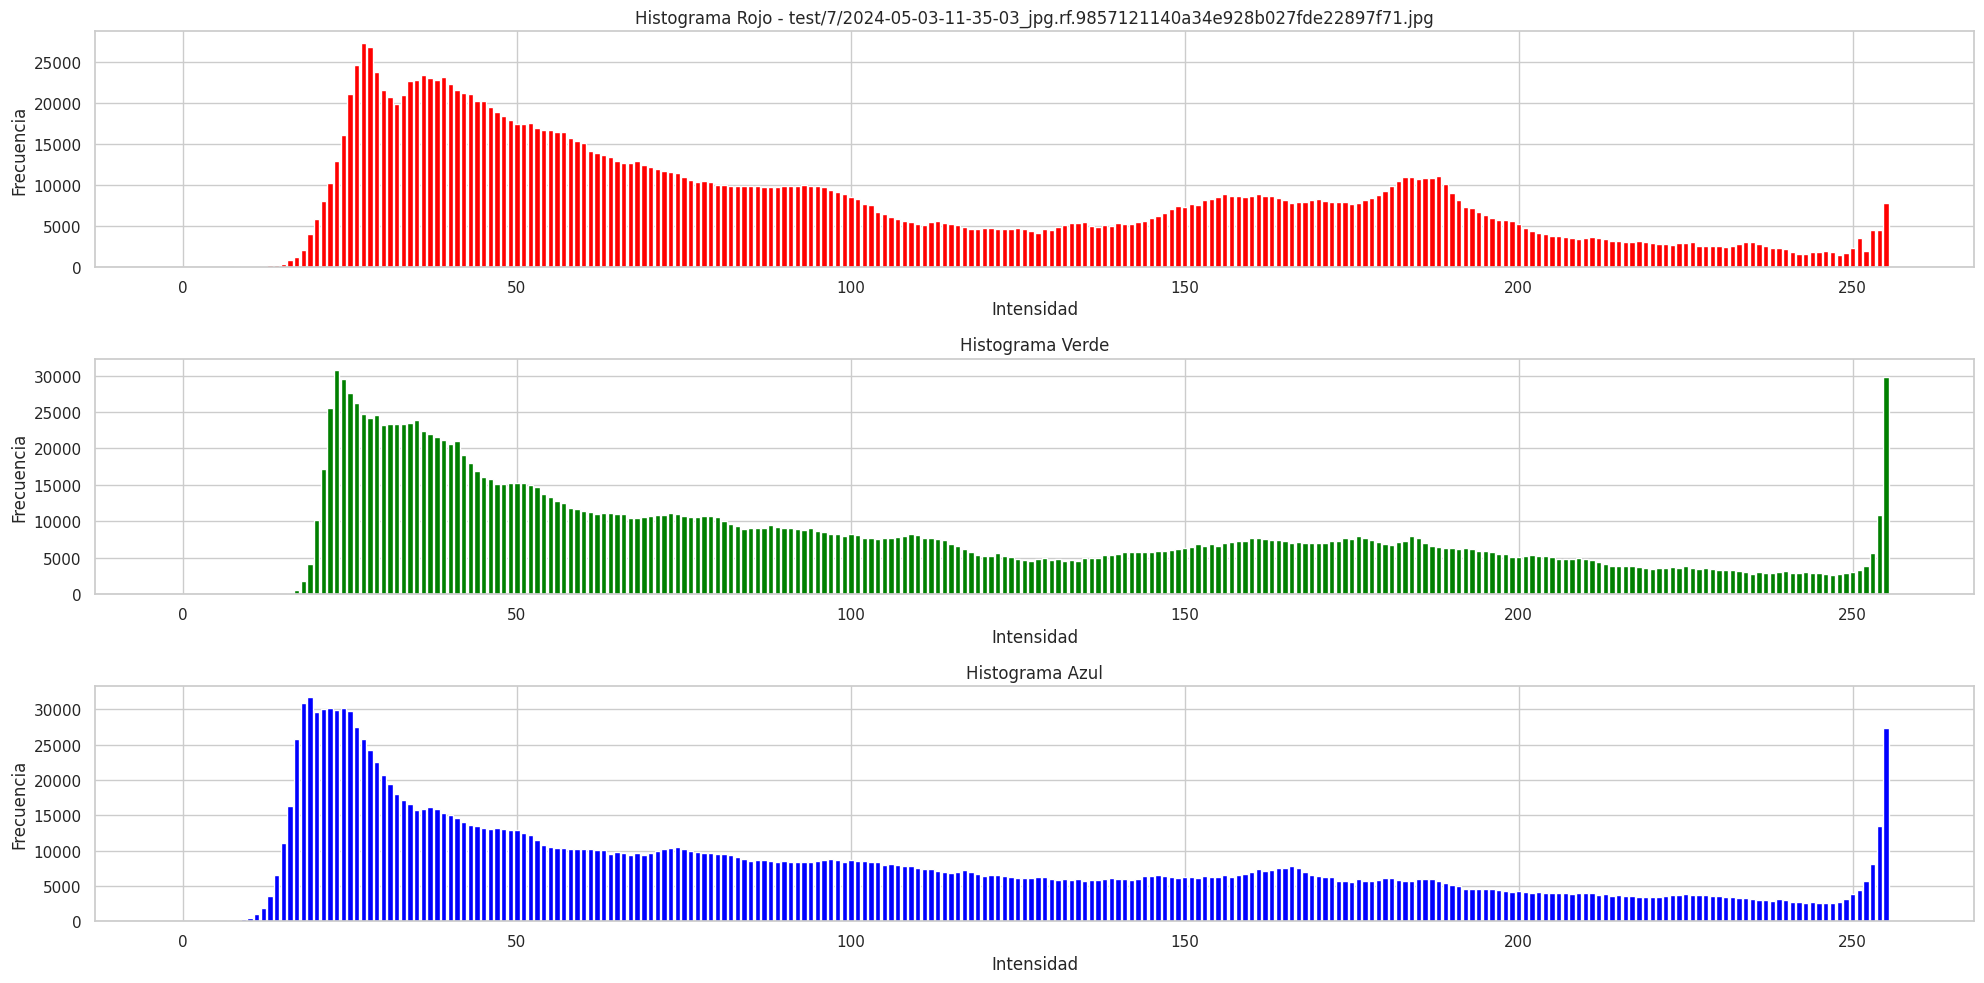

In [107]:
import random
import matplotlib.pyplot as plt

# Seleccionar una imagen al azar
random_index = random.randint(0, len(df)-1)
image_row = df.iloc[random_index]

# Extraer los histogramas
hist_red = image_row['Histogram_Red']
hist_green = image_row['Histogram_Green']
hist_blue = image_row['Histogram_Blue']

# Crear los histogramas
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)  # 3 filas, 1 columna, primer subplot
plt.bar(range(256), hist_red, color='red')
plt.title(f"Histograma Rojo - {image_row['Key']}")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.subplot(3, 1, 2)  # 3 filas, 1 columna, segundo subplot
plt.bar(range(256), hist_green, color='green')
plt.title("Histograma Verde")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.subplot(3, 1, 3)  # 3 filas, 1 columna, tercer subplot
plt.bar(range(256), hist_blue, color='blue')
plt.title("Histograma Azul")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


### Sobreponemos los 3 histogramas

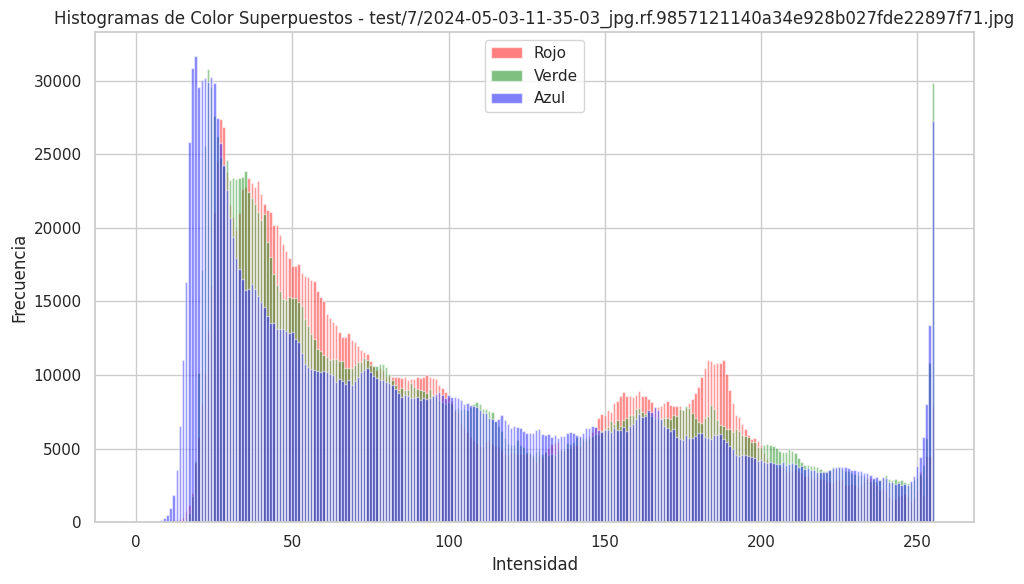

In [108]:
import matplotlib.pyplot as plt

# Crear una sola gráfica con los tres histogramas superpuestos
plt.figure(figsize=(10, 6))

plt.bar(range(256), hist_red, color='red', alpha=0.5, label='Rojo')
plt.bar(range(256), hist_green, color='green', alpha=0.5, label='Verde')
plt.bar(range(256), hist_blue, color='blue', alpha=0.5, label='Azul')

plt.title(f"Histogramas de Color Superpuestos - {image_row['Key']}")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()


### Creamos el histograma promedio de todo el dataset 

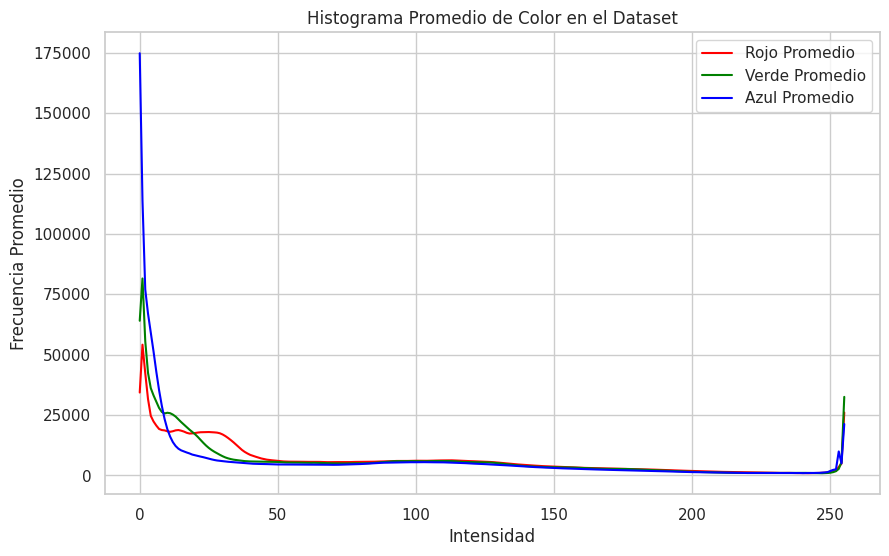

In [109]:
import numpy as np

# Inicializar arrays para acumular los histogramas
accum_hist_red = np.zeros(256)
accum_hist_green = np.zeros(256)
accum_hist_blue = np.zeros(256)

# Acumular los histogramas de todas las imágenes
for idx, row in df.iterrows():
    accum_hist_red += np.array(row['Histogram_Red'])
    accum_hist_green += np.array(row['Histogram_Green'])
    accum_hist_blue += np.array(row['Histogram_Blue'])

# Calcular los histogramas promedio
num_images = len(df)
avg_hist_red = accum_hist_red / num_images
avg_hist_green = accum_hist_green / num_images
avg_hist_blue = accum_hist_blue / num_images

# Graficar los histogramas promedio
plt.figure(figsize=(10, 6))
plt.plot(range(256), avg_hist_red, color='red', label='Rojo Promedio')
plt.plot(range(256), avg_hist_green, color='green', label='Verde Promedio')
plt.plot(range(256), avg_hist_blue, color='blue', label='Azul Promedio')
plt.title('Histograma Promedio de Color en el Dataset')
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia Promedio')
plt.legend()
plt.show()


### Graficamos la luminosidad y el contraste de las imágenes en el dataset

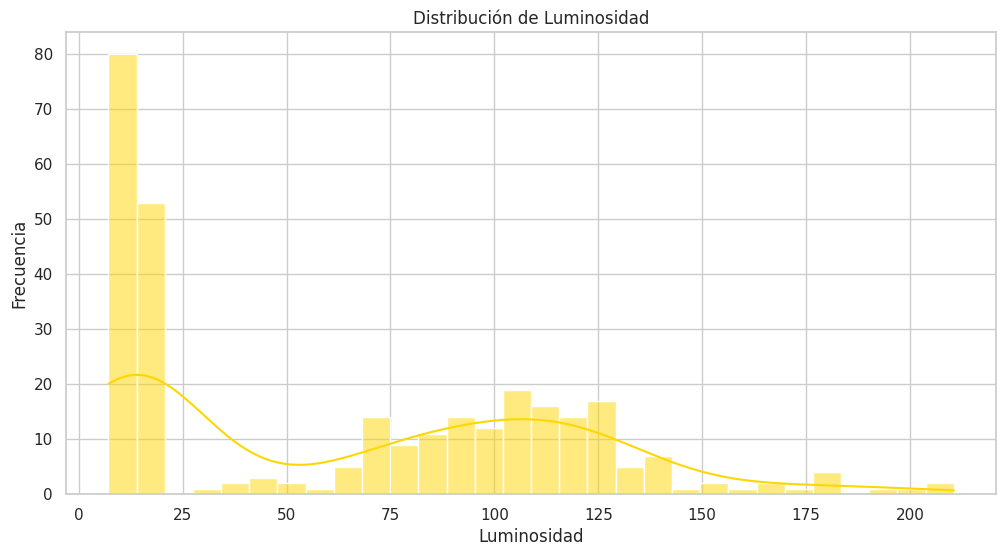

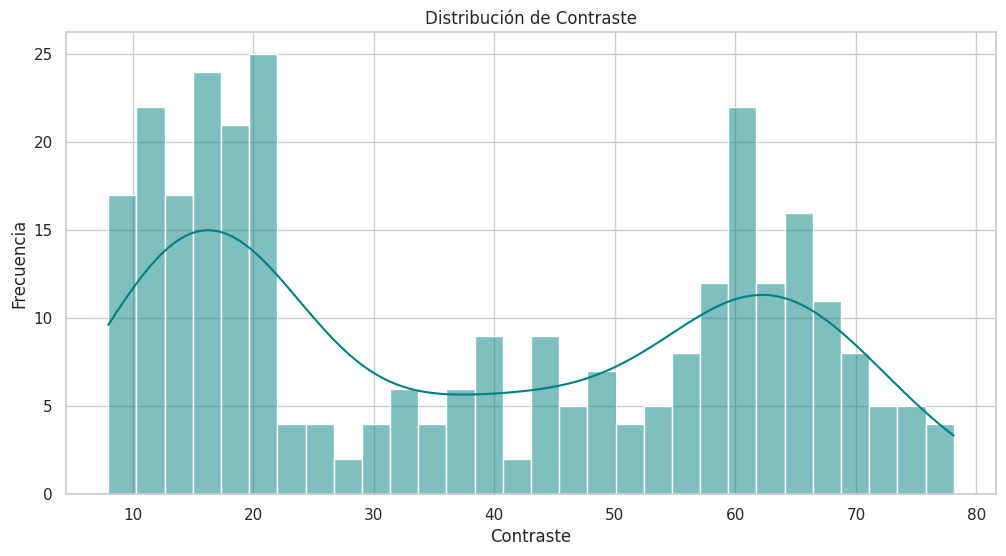

In [110]:
# Graficar la distribución de Luminosidad
plt.figure(figsize=(12, 6))
sns.histplot(df['Luminosity'], bins=30, kde=True, color='gold')
plt.title('Distribución de Luminosidad')
plt.xlabel('Luminosidad')
plt.ylabel('Frecuencia')
plt.show()

# Graficar la distribución de Contraste
plt.figure(figsize=(12, 6))
sns.histplot(df['Contrast'], bins=30, kde=True, color='teal')
plt.title('Distribución de Contraste')
plt.xlabel('Contraste')
plt.ylabel('Frecuencia')
plt.show()


### Vemos el promedio de luminosidad en el dataset

In [132]:
print(df['Luminosity'].describe())


count    300.000000
mean      65.148320
std       52.202773
min        7.138169
25%       13.737773
50%       70.113655
75%      108.023916
max      210.547877
Name: Luminosity, dtype: float64


### Definimos el rango de luminosidad como el promedio del datset

In [134]:
# Inicializar el cliente de S3
s3 = boto3.client('s3')

# Nombre del bucket
BUCKET_NAME = 'caetec-vacas'  # Reemplaza con tu nombre de bucket

# Definir el rango de luminosidad para la selección (por ejemplo, 15 a 25)
LUMINOSITY_TARGET = 70
LUMINOSITY_RANGE = 5  # +/-5
luminosity_min = LUMINOSITY_TARGET - LUMINOSITY_RANGE
luminosity_max = LUMINOSITY_TARGET + LUMINOSITY_RANGE


### Dividimos el dataset en cuantiles para tener 25%, 50% y 75%

In [136]:
# Calcular los cuartiles de la luminosidad
q1 = df['Luminosity'].quantile(0.25)
q3 = df['Luminosity'].quantile(0.75)
median_luminosity = df['Luminosity'].median()

print(f"Q1 (25%): {q1}")
print(f"Mediana (50%): {median_luminosity}")
print(f"Q3 (75%): {q3}")


Q1 (25%): 13.737772962782117
Mediana (50%): 70.11365540304301
Q3 (75%): 108.02391601562499


### Filtramos las imágenes según la cateroría de luminosidad, q1, q2 y q3

In [137]:
# Definir los rangos de luminosidad
luminosity_low_max = q1
luminosity_average_min = q1
luminosity_average_max = q3
luminosity_high_min = q3

# Filtrar imágenes por categoría
low_luminosity_df = df[df['Luminosity'] <= luminosity_low_max]
average_luminosity_df = df[(df['Luminosity'] > luminosity_average_min) & (df['Luminosity'] <= luminosity_average_max)]
high_luminosity_df = df[df['Luminosity'] > luminosity_high_min]

# Verificar el número de imágenes en cada categoría
print(f"Número de imágenes con baja luminosidad: {len(low_luminosity_df)}")
print(f"Número de imágenes con luminosidad promedio: {len(average_luminosity_df)}")
print(f"Número de imágenes con alta luminosidad: {len(high_luminosity_df)}")


Número de imágenes con baja luminosidad: 75
Número de imágenes con luminosidad promedio: 150
Número de imágenes con alta luminosidad: 75


### Función para descargar una imagen del s3 según la key

In [138]:
def download_image_from_s3(s3_client, bucket, key):
    try:
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_data = response['Body'].read()
        image = Image.open(BytesIO(image_data)).convert('RGB')  # Convertir a RGB si es necesario
        return image
    except Exception as e:
        print(f"Error al descargar o procesar la imagen {key}: {e}")
        return None


### Función para descargar 3 imágenes del s3 según las 3 categorías

In [139]:
# Función para seleccionar una imagen al azar de un DataFrame
def select_random_image(df_category):
    if df_category.empty:
        print("No hay imágenes en esta categoría.")
        return None
    return df_category.sample(n=1).iloc[0]

# Seleccionar una imagen de cada categoría
image_low = select_random_image(low_luminosity_df)
image_average = select_random_image(average_luminosity_df)
image_high = select_random_image(high_luminosity_df)


### Descargamos las 3 imágenes

In [140]:
# Descargar las imágenes
image_low_pil = download_image_from_s3(s3, BUCKET_NAME, image_low['Key']) if image_low is not None else None
image_average_pil = download_image_from_s3(s3, BUCKET_NAME, image_average['Key']) if image_average is not None else None
image_high_pil = download_image_from_s3(s3, BUCKET_NAME, image_high['Key']) if image_high is not None else None


### Mostramos las 3 imágenes, una para cada nivel de luminosidad

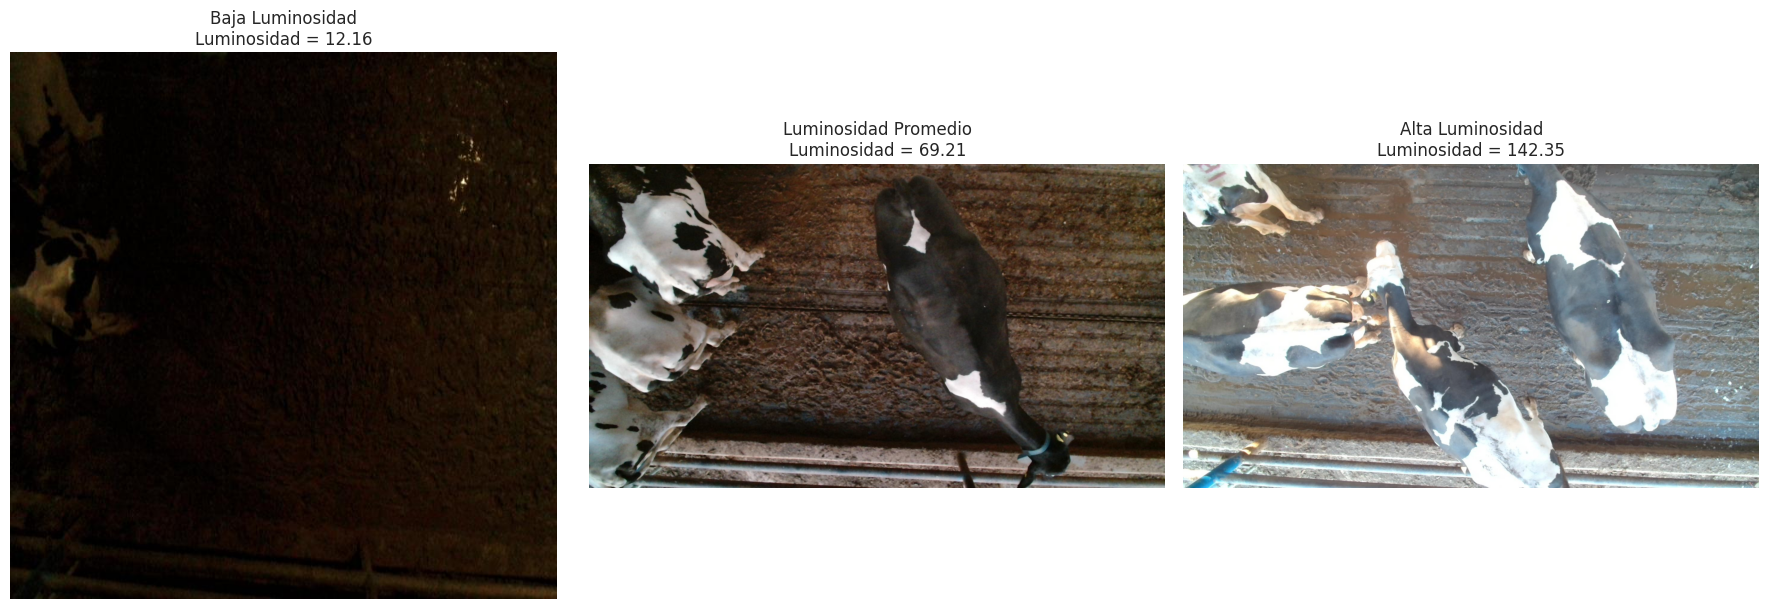

In [141]:
# Crear una figura con 3 subplots
plt.figure(figsize=(18, 6))

# Imagen de baja luminosidad
plt.subplot(1, 3, 1)
if image_low_pil:
    plt.imshow(image_low_pil)
    plt.title(f'Baja Luminosidad\nLuminosidad = {image_low["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

# Imagen de luminosidad promedio
plt.subplot(1, 3, 2)
if image_average_pil:
    plt.imshow(image_average_pil)
    plt.title(f'Luminosidad Promedio\nLuminosidad = {image_average["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

# Imagen de alta luminosidad
plt.subplot(1, 3, 3)
if image_high_pil:
    plt.imshow(image_high_pil)
    plt.title(f'Alta Luminosidad\nLuminosidad = {image_high["Luminosity"]:.2f}')
else:
    plt.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center')
plt.axis('off')

plt.tight_layout()
plt.show()